In [2]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/04-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/15-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [10]:
# basic libraries 
import os, re, math 
import numpy as np 
import pandas as pd 
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

# libraries for model 
from tensorflow.keras import optimizers, layers, models, utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [4]:
# finding the version of tf
import tensorflow as tf
print('Tensorflow version ' + tf.__version__)

Tensorflow version 2.4.1


In [5]:
# Setup TPU/detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of accelerators/replicas:', strategy.num_replicas_in_sync)


Device: grpc://10.0.0.2:8470


2022-09-13 13:51:55.893542: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-13 13:51:55.897349: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-09-13 13:51:55.897392: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-13 13:51:55.897421: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bee70723bdac): /proc/driver/nvidia/version does not exist
2022-09-13 13:51:55.902375: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of accelerators/replicas: 8


Loading the dataset from kaggle
When used with TPUs, datasets need to be stored in a Google Cloud Storage bucket.
You can use data from any public GCS bucket by giving its path just like you would data from '/kaggle/input'.
The following will retrieve the GCS path for this competition's dataset.

In [6]:
# Moving Data To Google Cloud Storage (GCS). TPUs require data to be present on GCS. The below utility copies the data to a GCS bucket co-located with the TPU.
# Using TFrecords often requires gsbucket address. You could get the gsbucket address by using kaggle API as below:

from kaggle_datasets import KaggleDatasets
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH)            # this is how the gsbucket address looks like OR say the path where the dataset is stored in cloud

gs://kds-2bd1874103d99fe39956f67874049e4f20213e5fa2476bf71e61e1e2


In [7]:
IMAGE_SIZE = [224, 224]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-224x224'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']  

2022-09-13 13:53:20.615586: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-13 13:53:20.769464: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-13 13:53:20.911117: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [8]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [11]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [12]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>


In [13]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
Training data label examples: [73 67 77 ... 74 34 75]


2022-09-13 13:56:37.842708: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 61, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1663077397.838112207","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 61, Output num: 0","grpc_status":3}


In [14]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
Test data IDs: ['b87e16bc0' 'd8437a7f7' '981396649' ... '15cb0c24a' '1c3a7bc99' 'b20b97998']


In [15]:
EPOCHS = 12

with strategy.scope():    
    densenet = tf.keras.applications.DenseNet201(
        input_shape = (224, 224, 3),
        weights = 'imagenet',  # Use the preset parameters of ImageNet
        include_top = False  # Drop the fully connected network on the top
    )
    
    densenet.trainable =True
    model = tf.keras.Sequential([
        densenet,
        #tf.keras.layers.Dropout(0.2),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', 
        metrics = ['sparse_categorical_accuracy']
    )

74842112/74836368 [==============================] - 0s 0us/step


In [17]:
from tensorflow import keras

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [18]:
NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,steps_per_epoch=STEPS_PER_EPOCH
)

Epoch 1/30
99/99 [==============================] - 175s 360ms/step - loss: 4.6647 - sparse_categorical_accuracy: 0.0497 - val_loss: 3.6504 - val_sparse_categorical_accuracy: 0.2462
Epoch 2/30
 1/99 [..............................] - ETA: 14s - loss: 3.7414 - sparse_categorical_accuracy: 0.2266

2022-09-13 14:02:24.520865: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 85023, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1663077744.520323231","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 85023, Output num: 1","grpc_status":3}


99/99 [==============================] - 17s 169ms/step - loss: 3.3305 - sparse_categorical_accuracy: 0.3149 - val_loss: 2.5771 - val_sparse_categorical_accuracy: 0.4628
Epoch 3/30
99/99 [==============================] - 17s 169ms/step - loss: 2.4862 - sparse_categorical_accuracy: 0.4983 - val_loss: 1.9441 - val_sparse_categorical_accuracy: 0.5973
Epoch 4/30
99/99 [==============================] - 17s 171ms/step - loss: 1.9887 - sparse_categorical_accuracy: 0.6064 - val_loss: 1.5501 - val_sparse_categorical_accuracy: 0.6870
Epoch 5/30
99/99 [==============================] - 17s 170ms/step - loss: 1.5978 - sparse_categorical_accuracy: 0.6915 - val_loss: 1.2822 - val_sparse_categorical_accuracy: 0.7333
Epoch 6/30
99/99 [==============================] - 17s 169ms/step - loss: 1.3396 - sparse_categorical_accuracy: 0.7432 - val_loss: 1.0997 - val_sparse_categorical_accuracy: 0.7713
Epoch 7/30
99/99 [==============================] - 17s 170ms/step - loss: 1.1491 - sparse_categorical_acc

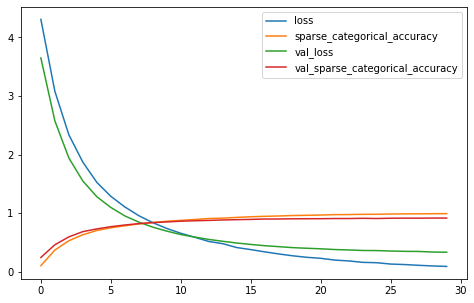

In [20]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

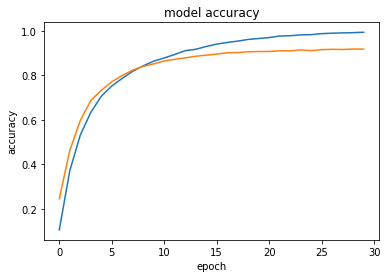

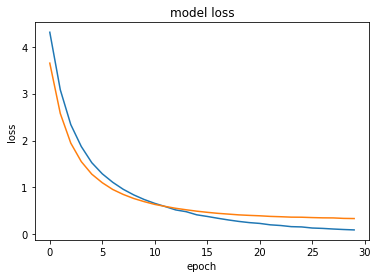

In [23]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend
plt.show()